In [32]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error, mean_squared_error, make_scorer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder

In [33]:
df = pd.read_csv("./Rumah.comdataset_v4.csv")
df = df.drop(columns=['Property Link', 'ID'])
df['Listing Area'] = df['Listing Area'].str.replace(' m²', '')
df = df.astype({'Listing Area':'int64'})
#Print the shape of the dataset before removing outliers
print(df.shape)

(22781, 7)


In [34]:
df.head()

,Price,Street Address,Bed,Bath,Listing Area,Certificate,Jakarta Division
0,2.960000e+09,Cempaka Putih,4,3,92,SHM - Sertifikat Hak Milik,CENTRAL
1,4.400000e+08,Salemba,2,2,40,SHM - Sertifikat Hak Milik,CENTRAL
2,2.900000e+09,Cempaka Putih,4,3,92,SHM - Sertifikat Hak Milik,CENTRAL
3,1.061321e+09,Cempaka Putih,2,2,58,SHM - Sertifikat Hak Milik,CENTRAL
4,1.061000e+09,Cempaka Putih,2,2,58,SHM - Sertifikat Hak Milik,CENTRAL


In [35]:
#Before we start, perform outlier detection and removal (removing all rows with outlier values) for numerical columns
outliers = pd.DataFrame()


numerical_cols = [cname for cname in df.columns if df[cname].dtype in ['int64', 'float64']]
#Keep removing outliers until there are no more outliers (run the loop 5 times)
for i in range(10):
    #Check if there are any outliers
    for col in numerical_cols:
        # Perform outlier detection using Interquartile Range (try using 0.95 -> more error)
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        # Before removing outliers, put the outliers in a separate dataframe
        outliers = outliers.append(df[(df[col] < Q1 - 1.5*IQR) | (df[col] > Q3 + 1.5*IQR)])
        # Remove outliers
        df = df[(df[col] >= Q1 - 1.5*IQR) & (df[col] <= Q3 + 1.5*IQR)]



#Print the shape of the dataset after outlier removal
print(df.shape)



(13045, 7)


/var/folders/p4/hlsdgszd7ysfnhxp8_f64bhm0000gn/T/ipykernel_31347/4199774308.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outliers = outliers.append(df[(df[col] < Q1 - 1.5*IQR) | (df[col] > Q3 + 1.5*IQR)])
/var/folders/p4/hlsdgszd7ysfnhxp8_f64bhm0000gn/T/ipykernel_31347/4199774308.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outliers = outliers.append(df[(df[col] < Q1 - 1.5*IQR) | (df[col] > Q3 + 1.5*IQR)])
/var/folders/p4/hlsdgszd7ysfnhxp8_f64bhm0000gn/T/ipykernel_31347/4199774308.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outliers = outliers.append(df[(df[col] < Q1 - 1.5*IQR) | (df[col] > Q3 + 1.5*IQR)])
/var/folders/p4/hlsdgszd7ysfnhxp8_f64bhm0000gn/T/ipykernel_31347/4199774308.py:15: FutureWarni

In [36]:
y = df.Price
X = df.drop(['Price'], axis=1)

In [37]:
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, 
                                                            train_size=0.8, test_size=0.2)

In [38]:
# cols_with_missing = [col for col in X_train_full.columns if X_train_full[col].isnull().any()] 
# X_train_full.drop(cols_with_missing, axis=1, inplace=True)
# X_valid_full.drop(cols_with_missing, axis=1, inplace=True)

In [39]:
low_cardinality_cols = [cname for cname in X_train_full.columns if X_train_full[cname].nunique() < 10 and 
                        X_train_full[cname].dtype == "object"]
high_cardinality_cols = [cname for cname in X_train_full.columns if X_train_full[cname].nunique() >= 10 and 
                        X_train_full[cname].dtype == "object"]
low_cardinality_cols, high_cardinality_cols

(['Jakarta Division'], ['Street Address', 'Certificate'])

In [40]:
numerical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype in ['int64', 'float64']]

In [41]:
numerical_cols

['Bed', 'Bath', 'Listing Area']

In [42]:
my_cols = low_cardinality_cols + high_cardinality_cols+ numerical_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()

In [43]:
# Get list of categorical variables
s = (X_train.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables:")
print(object_cols)

Categorical variables:
['Jakarta Division', 'Street Address', 'Certificate']


In [44]:
# Function for comparing different approaches
def score_dataset(X_train, X_valid, y_train, y_valid):
    model = RandomForestRegressor(n_estimators=100, random_state=0)
    #Use these hyperparameters for the best result (hyperparameter optimization applied)
    #{'n_estimators': 2000, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 40, 'bootstrap': True})
    model = RandomForestRegressor(n_estimators=2000, min_samples_split=10, min_samples_leaf=2, max_features='auto', max_depth=40, bootstrap=True, random_state=0)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    mae = mean_absolute_error(y_valid, preds)
    r2 = r2_score(y_valid, preds)
    #Get the number of samples and features in the validation set
    n_samples, n_features = X_train.shape
    #Calculate the degree of freedoms for residuals
    dof_residuals = n_samples - n_features - 1
    #Calculate the adjusted r2 score
    adj_r2 = 1 - (1 - r2) * (dof_residuals / (n_samples - 1))
    #calculate the root mean squared error
    rmse = np.sqrt(mean_squared_error(y_valid, preds))
    return mae, rmse,  adj_r2, mean_absolute_percentage_error(preds, y_valid)


In [45]:
# Function to optimize hyperparameters for Random Forest
#Return the parameters that give the best MAE
def optimize_rf(X_train, X_valid, y_train, y_valid):
    model = RandomForestRegressor(random_state=0)
    n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
    max_features = ['auto', 'sqrt']
    max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
    max_depth.append(None)
    min_samples_split = [2, 5, 10]
    min_samples_leaf = [1, 2, 4]
    bootstrap = [True, False]
    random_grid = {'n_estimators': n_estimators,
                     'max_features': max_features,
                        'max_depth': max_depth,
                        'min_samples_split': min_samples_split,
                        'min_samples_leaf': min_samples_leaf,
                        'bootstrap': bootstrap}
    #The target metric is MAE
    scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)
    rf_random = RandomizedSearchCV(estimator = model, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1, scoring=scorer)
    rf_random.fit(X_train, y_train)
    preds = rf_random.predict(X_valid)
    mae = mean_absolute_error(y_valid, preds)
    r2 = r2_score(y_valid, preds)
    #Get the number of samples and features in the validation set
    n_samples, n_features = X_train.shape
    #Calculate the degree of freedoms for residuals
    dof_residuals = n_samples - n_features - 1
    #Calculate the adjusted r2 score
    adj_r2 = 1 - (1 - r2) * (dof_residuals / (n_samples - 1))
    #calculate the root mean squared error
    rmse = np.sqrt(mean_squared_error(y_valid, preds))
    return mae, rmse, adj_r2, rf_random.best_params_

In [46]:
# Using approach 1: Drop Categorical Variables
drop_X_train = X_train.select_dtypes(exclude=['object'])
drop_X_valid = X_valid.select_dtypes(exclude=['object'])

print("MAE, RMSE, Adjusted R2 from Approach 1 (Drop categorical variables):")
print(score_dataset(drop_X_train, drop_X_valid, y_train, y_valid))

MAE, RMSE, Adjusted R2 from Approach 1 (Drop categorical variables):


/Users/ariel/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


(772782139.7057855, 1056163936.0927906, 0.5517827469002592, 0.3015243546748877)


In [47]:
from sklearn.preprocessing import OrdinalEncoder

# Make copy to avoid changing original data 
label_X_train = X_train.copy()
label_X_valid = X_valid.copy()

# Apply ordinal encoder to each column with categorical data
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
label_X_train[object_cols] = ordinal_encoder.fit_transform(X_train[object_cols])
label_X_valid[object_cols] = ordinal_encoder.transform(X_valid[object_cols])

print(label_X_valid.head())

print("MAE, R2, Adjusted R2 from Approach 2 (Ordinal Encoding):") 
print(score_dataset(label_X_train, label_X_valid, y_train, y_valid))

MAE, R2, Adjusted R2 from Approach 2 (Ordinal Encoding):


/Users/ariel/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


(624773651.1749066, 911280547.9232556, 0.666416016233873, 0.24321430483521053)


In [48]:
#Make a dataframe whose columns are before and after encoding
encoder_explanation = pd.DataFrame(columns=['before encoding', 'after encoding'])

#Print the lists for each categorical variable (before and after encoding)
#Put them in three separate columns in a dataframe for easy comparison
#The columns are: before encoding, after encoding
#The rows are categorical variable + value (as "before encoding") and the corresponding encoded value (as "after encoding")
for col in object_cols:
    for i in range(len(X_train[col].unique())):
        encoder_explanation.loc[col + ' ' + str(X_train[col].unique()[i]), 'variable'] = col
        encoder_explanation.loc[col + ' ' + str(X_train[col].unique()[i]), 'before encoding'] = X_train[col].unique()[i]
        encoder_explanation.loc[col + ' ' + str(X_train[col].unique()[i]), 'after encoding'] = label_X_train[col].unique()[i]
        #Also add the number of validation samples that have this value
        encoder_explanation.loc[col + ' ' + str(X_train[col].unique()[i]), 'n_samples'] = len(X_valid[X_valid[col] == X_train[col].unique()[i]])
        
#Order the dataframe firstly by the categorical variable name
#Then by the "after encoding" value
encoder_explanation = encoder_explanation.sort_values(by=['variable', 'after encoding'])


#Save the encoder_explanation dataframe to a csv file
encoder_explanation.to_csv('ordinal_encoder_explanation.csv')


In [49]:
#Using Ordinal Encoding with Hyperparameter Optimization
# print("MAE, R2, Adjusted R2 from Approach 2 (Ordinal Encoding) with Hyperparameter Optimization:")
# print(optimize_rf(label_X_train, label_X_valid, y_train, y_valid))

In [50]:
# Apply one-hot encoder to each column with categorical data
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train[object_cols]))
OH_cols_valid = pd.DataFrame(OH_encoder.transform(X_valid[object_cols]))

#To remove warnings
OH_cols_train.columns = OH_cols_train.columns.astype('str')
OH_cols_valid.columns = OH_cols_valid.columns.astype('str')

# One-hot encoding removed index; put it back
OH_cols_train.index = X_train.index
OH_cols_valid.index = X_valid.index

# Remove categorical columns (will replace with one-hot encoding)
num_X_train = X_train.drop(object_cols, axis=1)
num_X_valid = X_valid.drop(object_cols, axis=1)

# Add one-hot encoded columns to numerical features
OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
OH_X_valid = pd.concat([num_X_valid, OH_cols_valid], axis=1)

print(OH_X_train.head())

print("MAE from Approach 3 (One-Hot Encoding):") 
print(score_dataset(OH_X_train, OH_X_valid, y_train, y_valid))

/Users/ariel/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/ariel/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


       Bed  Bath  Listing Area    0    1    2    3    4    5    6  ...  206  \
563      4     2           200  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
20037    4     3           240  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...  0.0   
4597     2     2            80  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...  0.0   
7132     3     3            98  0.0  1.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
20193    2     1            70  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...  0.0   

       207  208  209  210  211  212  213  214  215  
563    0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  
20037  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  
4597   0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  
7132   0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
20193  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 219 columns]
MAE from Approach 3 (One-Hot Encoding):
(627520555.2589545, 915529339.3170905, 0.6701748713767454, 0.24374368724280618)


In [51]:
# #Using OneHot Encoding with Hyperparameter Optimization -> no need; already done
# print("MAE, R2, Adjusted R2 from Approach 2 (Ordinal Encoding) with Hyperparameter Optimization:")
# print(optimize_rf(OH_X_train, OH_X_valid, y_train, y_valid))


In [52]:
low_cardinality_cols = [cname for cname in X_train_full.columns if X_train_full[cname].nunique() < 10 and 
                        X_train_full[cname].dtype == "object"]
high_cardinality_cols = [cname for cname in X_train_full.columns if X_train_full[cname].nunique() >= 10 and 
                        X_train_full[cname].dtype == "object"]
low_cardinality_cols, high_cardinality_cols

(['Jakarta Division'], ['Street Address', 'Certificate'])

In [61]:
# Make copy to avoid changing original data 
mix_X_train = X_train.copy()
mix_X_valid = X_valid.copy()

# Apply ordinal encoder to each column with categorical data
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
mix_X_train[high_cardinality_cols] = ordinal_encoder.fit_transform(X_train[high_cardinality_cols])
mix_X_valid[high_cardinality_cols] = ordinal_encoder.transform(X_valid[high_cardinality_cols])

# Apply one-hot encoder to each column with categorical data
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(mix_X_train[low_cardinality_cols]))
OH_cols_valid = pd.DataFrame(OH_encoder.transform(mix_X_valid[low_cardinality_cols]))

#To remove warnings
OH_cols_train.columns = OH_cols_train.columns.astype('str')
OH_cols_valid.columns = OH_cols_valid.columns.astype('str')

# One-hot encoding removed index; put it back
OH_cols_train.index = X_train.index
OH_cols_valid.index = X_valid.index

# Remove categorical columns (will replace with one-hot encoding)
num_X_train = mix_X_train.drop(low_cardinality_cols, axis=1)
num_X_valid = mix_X_valid.drop(low_cardinality_cols, axis=1)

# Add one-hot encoded columns to numerical features
OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
OH_X_valid = pd.concat([num_X_valid, OH_cols_valid], axis=1)

print(OH_X_valid.head())

# print("MAE from Approach 4 (Ordinal Encoding + One-Hot Encoding):") 
print(score_dataset(OH_X_train, OH_X_valid, y_train, y_valid))

/Users/ariel/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/ariel/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


       Street Address  Certificate  Bed  Bath  Listing Area    0    1    2  \
22210           121.0          7.0    3     2           160  0.0  0.0  1.0   
9571            121.0          5.0    3     3            54  0.0  0.0  1.0   
21889           121.0          8.0    3     3           120  0.0  0.0  1.0   
14449            94.0          7.0    5     4           240  0.0  0.0  1.0   
16845           193.0          7.0    3     2            80  0.0  0.0  0.0   

         3    4  
22210  0.0  0.0  
9571   0.0  0.0  
21889  0.0  0.0  
14449  0.0  0.0  
16845  0.0  1.0  
(628382216.5422353, 913778128.4175794, 0.6647136254560712, 0.2460911444734443)


In [54]:
y_valid.mean()

2730996201.8386354

In [55]:
low_cardinality_cols = [cname for cname in X_train_full.columns if X_train_full[cname].nunique() < 10 and 
                        X_train_full[cname].dtype == "object"]
high_cardinality_cols = [cname for cname in X_train_full.columns if X_train_full[cname].nunique() >= 10 and 
                        X_train_full[cname].dtype == "object"]
low_cardinality_cols, high_cardinality_cols

(['Jakarta Division'], ['Street Address', 'Certificate'])

/var/folders/p4/hlsdgszd7ysfnhxp8_f64bhm0000gn/T/ipykernel_31347/346260603.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, fmt='.1g')


<Axes: >

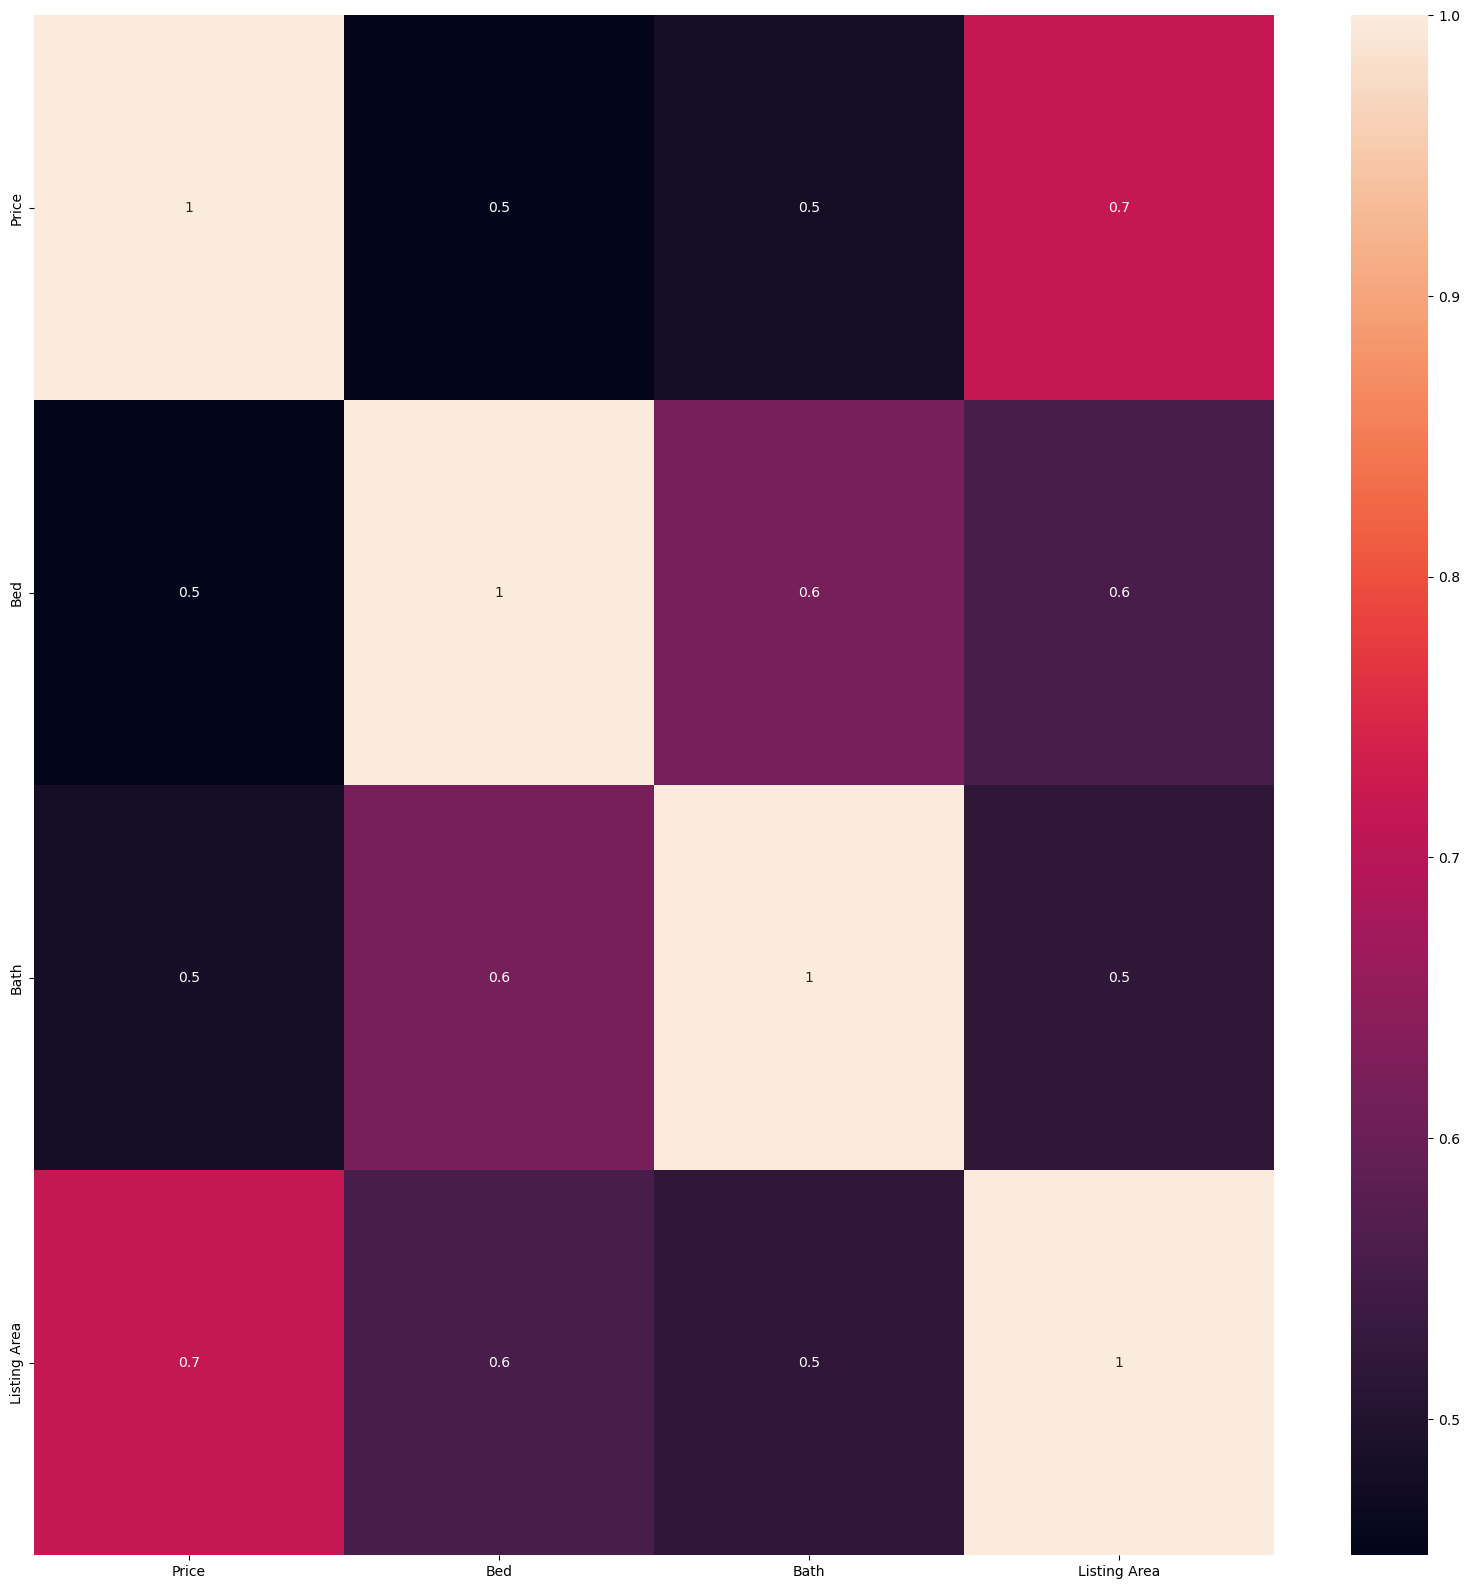

In [56]:
#Try to visualize the data to see if there is any correlation between the features and the target
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(20, 20))
sns.heatmap(df.corr(), annot=True, fmt='.1g')


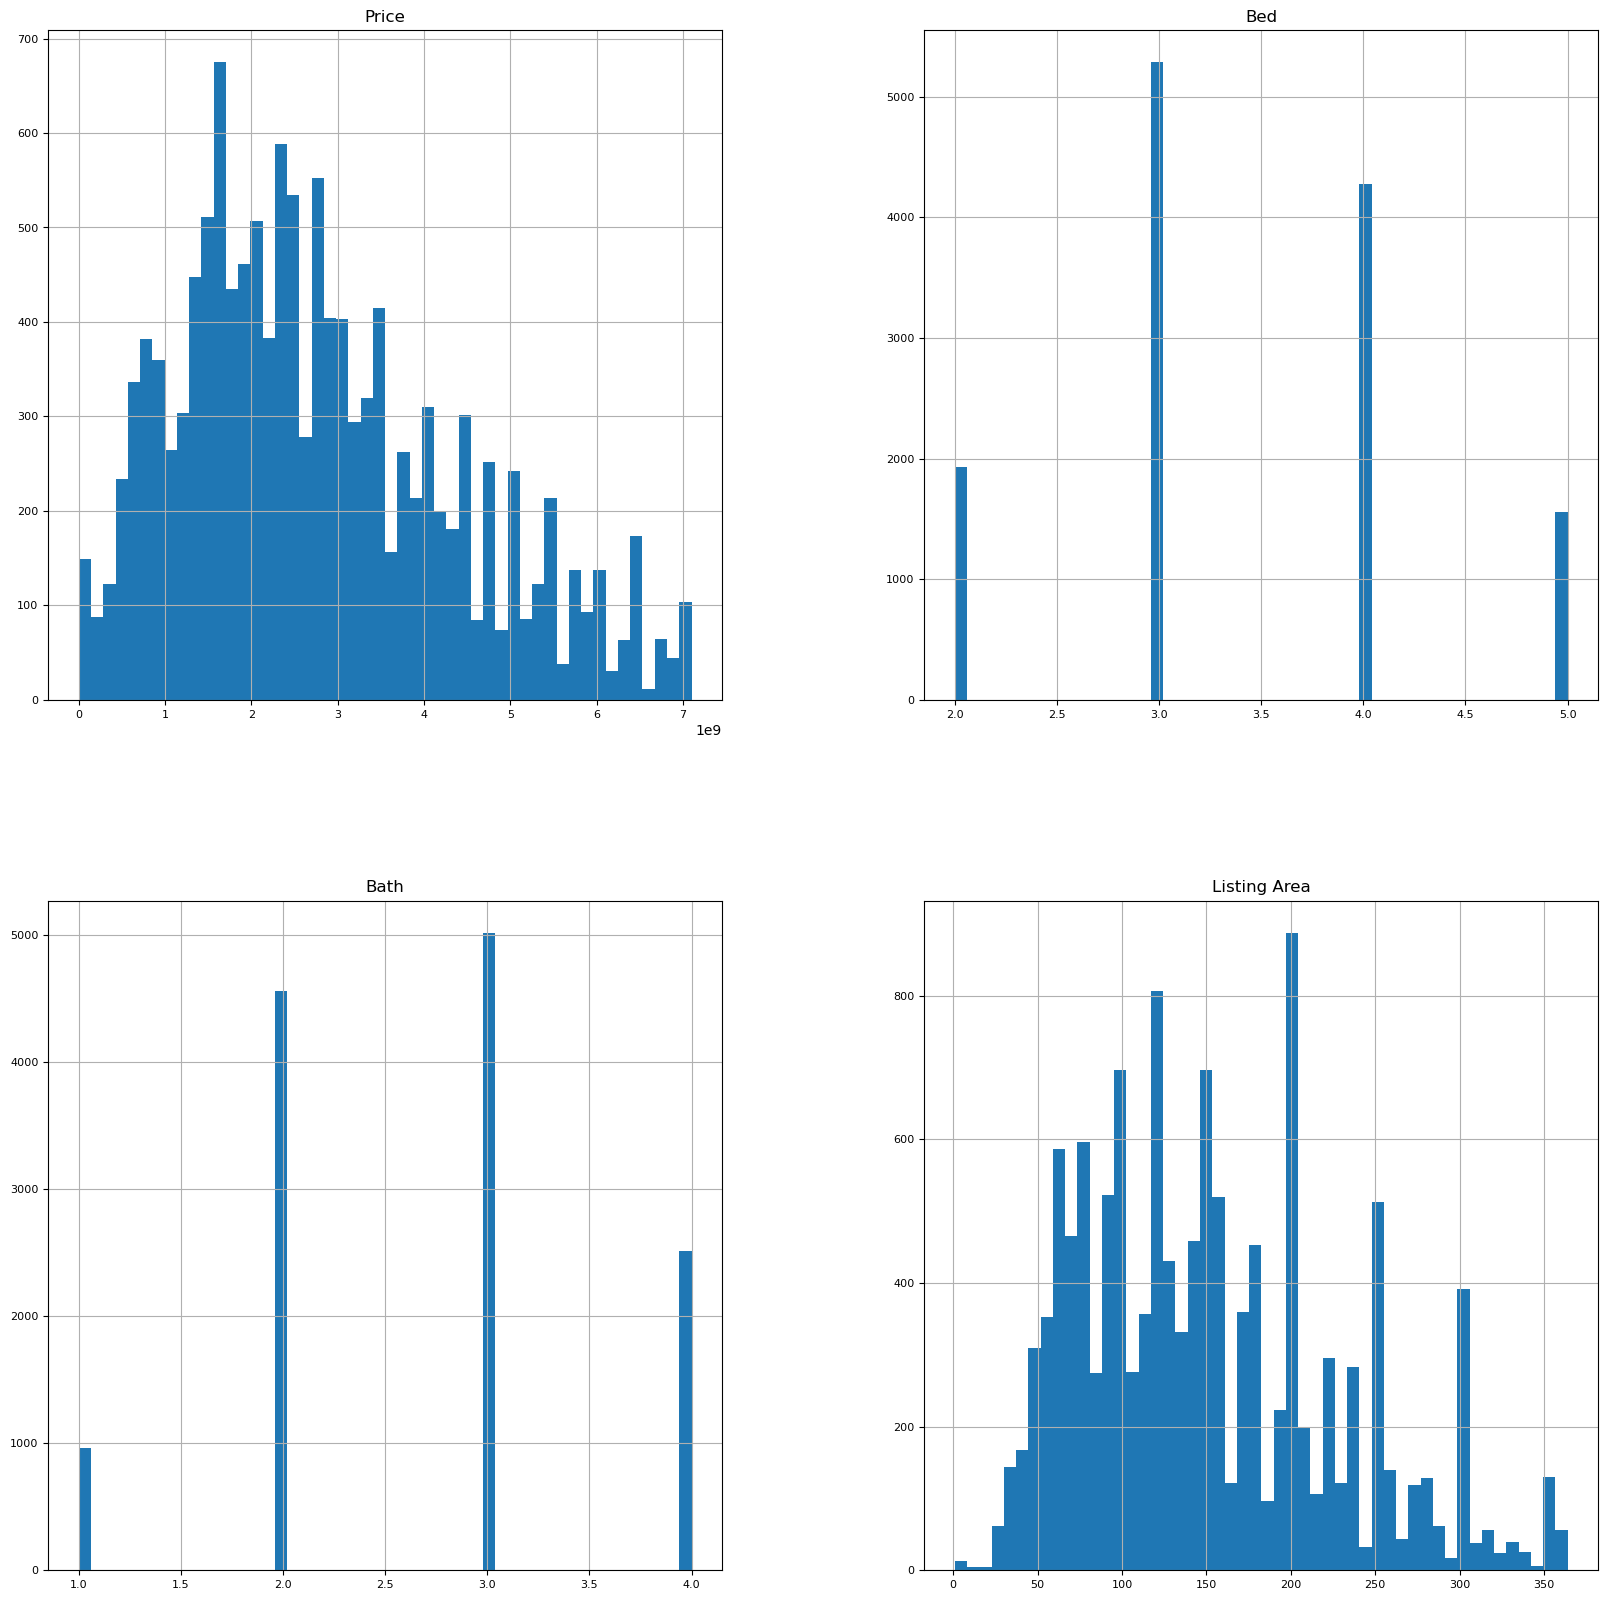

In [57]:
#Check the histograms of all the features
df.hist(figsize=(20, 20), bins=50, xlabelsize=8, ylabelsize=8); # ; avoid having the matplotlib verbose informations


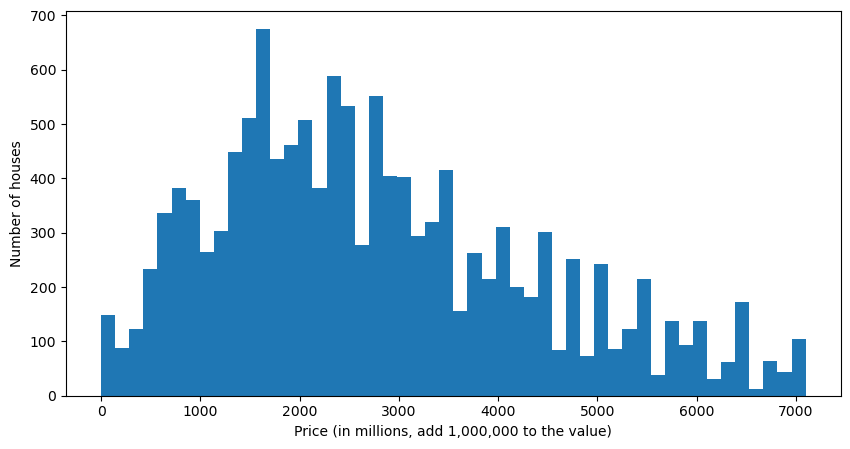

In [58]:
#Specifically make a histogram only for price, but this time write the full scale of the x value (in millions)
plt.figure(figsize=(10, 5))
#Divide the price by 1,000,000 and add the text "M" to the x label
plt.hist(df['Price']/1000000, bins=50)
plt.xlabel('Price (in millions, add 1,000,000 to the value)')
plt.ylabel('Number of houses')
plt.show()

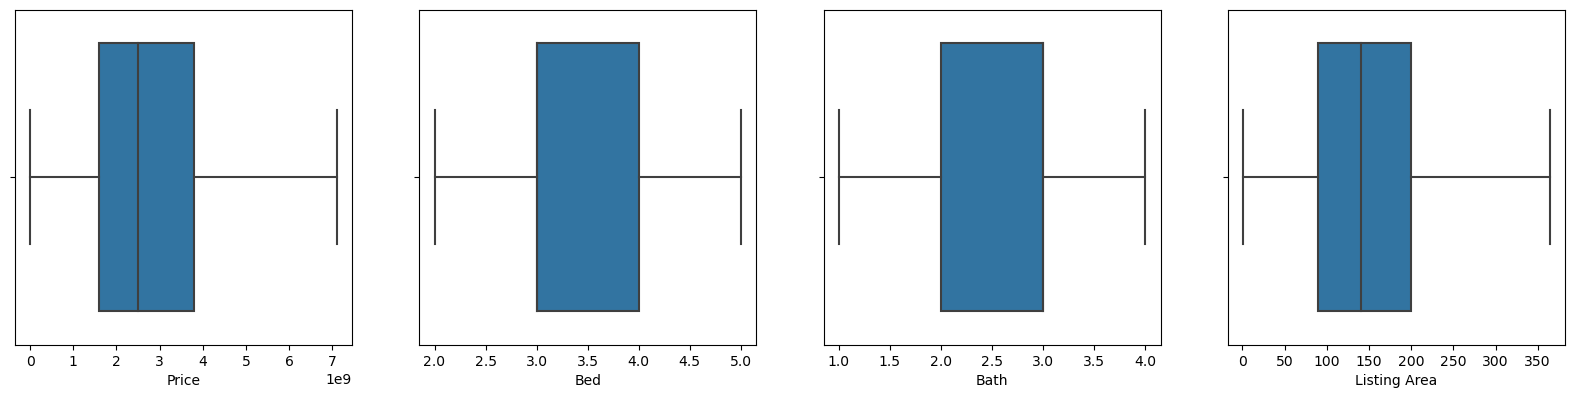

In [59]:
#Perform outlier detection by plotting boxplots for the numerical features
plt.figure(figsize=(20, 20))
#Get all columns with numerical data from df
numerical_cols = [cname for cname in df.columns if df[cname].dtype in ['int64', 'float64']]
#Plot boxplots for all numerical columns
for i in range(len(numerical_cols)):
    plt.subplot(4, 4, i+1)
    sns.boxplot(x=df[numerical_cols[i]])


In [60]:
#Print the top 10 rows with the highest price
df.sort_values(by=['Price'], ascending=False).head(50)

,Price,Street Address,Bed,Bath,Listing Area,Certificate,Jakarta Division
22140,7.100000e+09,Pantai Indah Kapuk,3,4,303,PPJB - Perjanjian Pengikatan Jual Beli,NORTH
8452,7.100000e+09,Sunter,4,3,260,SHM - Sertifikat Hak Milik,NORTH
19093,7.087000e+09,Pantai Indah Kapuk,4,4,224,SHM - Sertifikat Hak Milik,NORTH
15001,7.055000e+09,Pantai Mutiara,4,3,194,SHM - Sertifikat Hak Milik,NORTH
19092,7.030000e+09,Pantai Indah Kapuk,4,4,278,SHM - Sertifikat Hak Milik,NORTH
932,7.000000e+09,Gunung Sahari,4,4,300,SHM - Sertifikat Hak Milik,CENTRAL
4333,7.000000e+09,Tebet,5,4,200,SHM - Sertifikat Hak Milik,SOUTH
22589,7.000000e+09,Pantai Indah Kapuk,4,3,227,SHM - Sertifikat Hak Milik,NORTH
11029,7.000000e+09,Joglo,2,4,245,SHM - Sertifikat Hak Milik,WEST
19096,7.000000e+09,Pantai Indah Kapuk,5,4,240,PPJB - Perjanjian Pengikatan Jual Beli,NORTH
